# Overview
In this notebook we load the data and view different images to get a better idea about the challenge weare facing. This is always a very helpful first step. It is also important that you can see and try to makesome of your own predictions about the data. If you cannot see differences between the groups it is goingto be difficult for a biomarker to capture that (but not necessarily impossible)

In [3]:
# special functions for using pyradiomics
from SimpleITK import GetImageFromArray
import radiomics
from radiomics.featureextractor import RadiomicsFeatureExtractor
# This module is used for interaction with pyradiomic
import logging
logging.getLogger('radiomics').setLevel(logging.CRITICAL + 1)
# this tool makes a whole TON of log noise

### Setup the PyRadiomics Code

In [4]:
# Instantiate the extractor
texture_extractor = RadiomicsFeatureExtractor(verbose=False)
texture_extractor.disableAllFeatures()
_text_feat = {ckey: [] for ckey in texture_extractor.featureClassNames}
texture_extractor.enableFeaturesByName(**_text_feat)

print('Extraction parameters:\n\t', texture_extractor.settings)
print('Enabled filters:\n\t', texture_extractor.enabledImagetypes)
print('Enabled features:\n\t', texture_extractor.enabledFeatures) 

Extraction parameters:
	 {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'verbose': False}
Enabled filters:
	 {'Original': {}}
Enabled features:
	 {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': [], 'shape2D': []}


In [5]:
import numpy as np # for manipulating 3d images
import pandas as pd # for reading and writing tables
import h5py # for reading the image files
import skimage # for image processing and visualizations
import sklearn # for machine learning and statistical models
import os # help us load files and deal with paths
from pathlib import Path # help manage files

##### Plot Setup Code
Here we setup the defaults to make the plots look a bit nicer for the notebook

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})

### Load all of the images
We start with the training data since we have labels for them and can look in more detail

In [7]:
data_root = Path('.') / 'data_MRI'
all_df = pd.DataFrame({'h5_path': list(data_root.glob('*/*.h5'))})
all_df['file_id'] = all_df['h5_path'].map(lambda x: x.stem)
all_df['training_group'] = all_df['h5_path'].map(lambda x: x.parent.stem)
all_df['scan_id'] = all_df['file_id'].map(lambda x:int(x.split('_')[-1]))
all_df.head(5) # show the first 5 lines

,h5_path,file_id,training_group,scan_id
0,data_MRI\test\mri_00000273.h5,mri_00000273,test,273
1,data_MRI\test\mri_00041615.h5,mri_00041615,test,41615
2,data_MRI\test\mri_00062974.h5,mri_00062974,test,62974
3,data_MRI\test\mri_00078322.h5,mri_00078322,test,78322
4,data_MRI\test\mri_00087269.h5,mri_00087269,test,87269


### Read Image

In [8]:
def read_scan(full_scan_path):
    # load the image using hdf5
    with h5py.File(full_scan_path, 'r') as h:
    # [::2, ::4, ::4, 0] downsampling makes it go much faster
        return h['image'][:][:, :, :, 0] # we read the data from the file

### Load a Scan
- the data on kaggle are located in a parent folder called input.
- Since the files have been organized into train and test we use the train folder

In [9]:
sample_scan = all_df.iloc[0] # just take the first row
print(sample_scan)
# turn the h5_path into the full path
image_data = read_scan(sample_scan['h5_path'])
print('Image Shape:', image_data.shape)

h5_path           data_MRI\test\mri_00000273.h5
file_id                            mri_00000273
training_group                             test
scan_id                                     273
Name: 0, dtype: object
Image Shape: (176, 208, 176)


### Calculate Radiomic Features
Calculate the radiomic features for the test scan

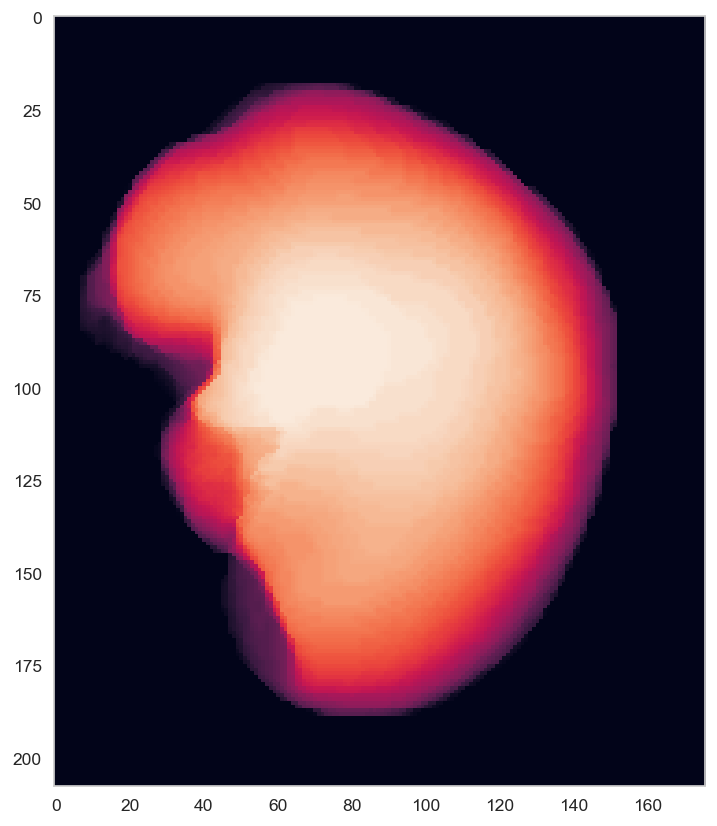

In [10]:
# we take a mask by just keeping the part of the image greater than 0
plt.imshow(np.sum((image_data>0).astype(float), 0))

In [11]:
%%time
results = texture_extractor.execute(GetImageFromArray(image_data), GetImageFromArray((image_data>0).astype(np.uint8)))

CPU times: total: 58.6 s
Wall time: 59.2 s


In [12]:
pd.DataFrame([results]).T

,0
diagnostics_Versions_PyRadiomics,v3.0.1
diagnostics_Versions_Numpy,1.24.2
diagnostics_Versions_SimpleITK,2.2.1
diagnostics_Versions_PyWavelet,1.4.1
diagnostics_Versions_Python,3.11.2
...,...
original_ngtdm_Busyness,15.255198930699823
original_ngtdm_Coarseness,1.4086722031134004e-05
original_ngtdm_Complexity,8720.357148826395
original_ngtdm_Contrast,0.05524315993345906


In [13]:
def calc_radiomics(in_image_data):
    return texture_extractor.execute(GetImageFromArray(in_image_data), GetImageFromArray((in_image_data>0).astype(np.uint8)))

##### Run over all scans
We use the .map function from pandas to calculate the brightness for all the scans

In [14]:
%%time
all_df['radiomics'] = all_df['h5_path'].map(lambda c_filename: calc_radiomics(read_scan(c_filename)))

CPU times: total: 21min 10s
Wall time: 21min 21s


In [15]:
full_df = pd.DataFrame([dict(**c_row.pop('radiomics'), **c_row) for _, c_row in all_df.iterrows()])
print(full_df.shape, 'data prepared')
first_cols = all_df.columns[:-1].tolist()
full_df = full_df[first_cols + [c_col for c_col in full_df.columns if c_col not in first_cols]]
# export the whole table
full_df.to_csv('all_radiomics_table.csv', index=False)
full_df.sample(3)

(32, 133) data prepared


,h5_path,file_id,training_group,scan_id,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
29,data_MRI\test\mri_00971022.h5,mri_00971022,test,971022,v3.0.1,1.24.2,2.2.1,1.4.1,3.11.2,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,605.4277626212129,0.0019303703563467443,7.936013943477547,0.28609506352923114,3806.5296326367793,13.964703918531516,1.7186171307110537e-05,10994.845582417238,0.07354231136923506,0.10820809590475428
31,data_MRI\train\mri_00014004.h5,mri_00014004,train,14004,v3.0.1,1.24.2,2.2.1,1.4.1,3.11.2,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,674.2285997434947,0.0013475424807176597,7.754752205637618,0.2731163151126636,17936.351431514544,13.142290090001707,1.2633104140214638e-05,18016.12416936799,0.04370105051910675,0.15271688205796485
21,data_MRI\test\mri_00790224.h5,mri_00790224,test,790224,v3.0.1,1.24.2,2.2.1,1.4.1,3.11.2,"{'minimumROIDimensions': 2, 'minimumROISize': ...",...,774.4901645688508,0.0015736477710227548,7.879935874201501,0.3426140071398411,1633.0892493842025,15.759627826363163,1.3647457484887707e-05,15224.828447285365,0.10876499802132171,0.08750125643846207


### Focusing on Interesting Radiomics

In [16]:
# leave out anything that doesn't start with original (just junk from the input)
# also remove shape since it is not very informative
value_feature_names = [c_col for c_col in full_df.columns if (c_col.startswith('original') and '_shape_' not in c_col)]
print(np.random.choice(value_feature_names, 3), 'of', len(value_feature_names))

['original_glcm_ClusterProminence'
 'original_glrlm_RunLengthNonUniformityNormalized'
 'original_glcm_ClusterShade'] of 93


In [17]:
# make a cleaner vefirst_colson
clean_df = full_df[first_cols + value_feature_names].copy()
clean_df.columns = first_cols + [
' '.join(c_col.split('original_')[-1].split('_')) for c_col in value_feature_names
]
clean_col_names = clean_df.columns[len(first_cols):]
# fix some of the artifacts from the radiomics tool
obj_cols = clean_df[clean_col_names].select_dtypes(['object']).columns.tolist()
for c_col in obj_cols:
    clean_df[c_col] = clean_df[c_col].map(lambda x:float(x))
clean_df.to_csv('clean_radiomics_table.csv', index=False)
clean_df.sample(3)

,h5_path,file_id,training_group,scan_id,firstorder 10Percentile,firstorder 90Percentile,firstorder Energy,firstorder Entropy,firstorder InterquartileRange,firstorder Kurtosis,...,glszm SmallAreaHighGrayLevelEmphasis,glszm SmallAreaLowGrayLevelEmphasis,glszm ZoneEntropy,glszm ZonePercentage,glszm ZoneVariance,ngtdm Busyness,ngtdm Coarseness,ngtdm Complexity,ngtdm Contrast,ngtdm Strength
3,data_MRI\test\mri_00078322.h5,mri_00078322,test,78322,296.0,1438.0,1.572014e+12,5.879034,665.0,1.944152,...,769.458289,0.001686,7.875644,0.357857,2071.238458,17.428355,0.000014,15711.274912,0.112517,0.094684
13,data_MRI\test\mri_00448143.h5,mri_00448143,test,448143,302.0,1442.0,1.587527e+12,5.858048,695.0,1.855843,...,706.515778,0.002204,7.795429,0.356046,2364.140540,16.684101,0.000014,15638.416748,0.114880,0.091628
30,data_MRI\train\mri_00004519.h5,mri_00004519,train,4519,300.0,1441.0,1.622474e+12,5.854771,671.0,1.998446,...,777.002411,0.001782,7.848166,0.352477,2118.973015,12.224553,0.000014,25751.363640,0.079092,0.167631


### Show the distribution of different variables

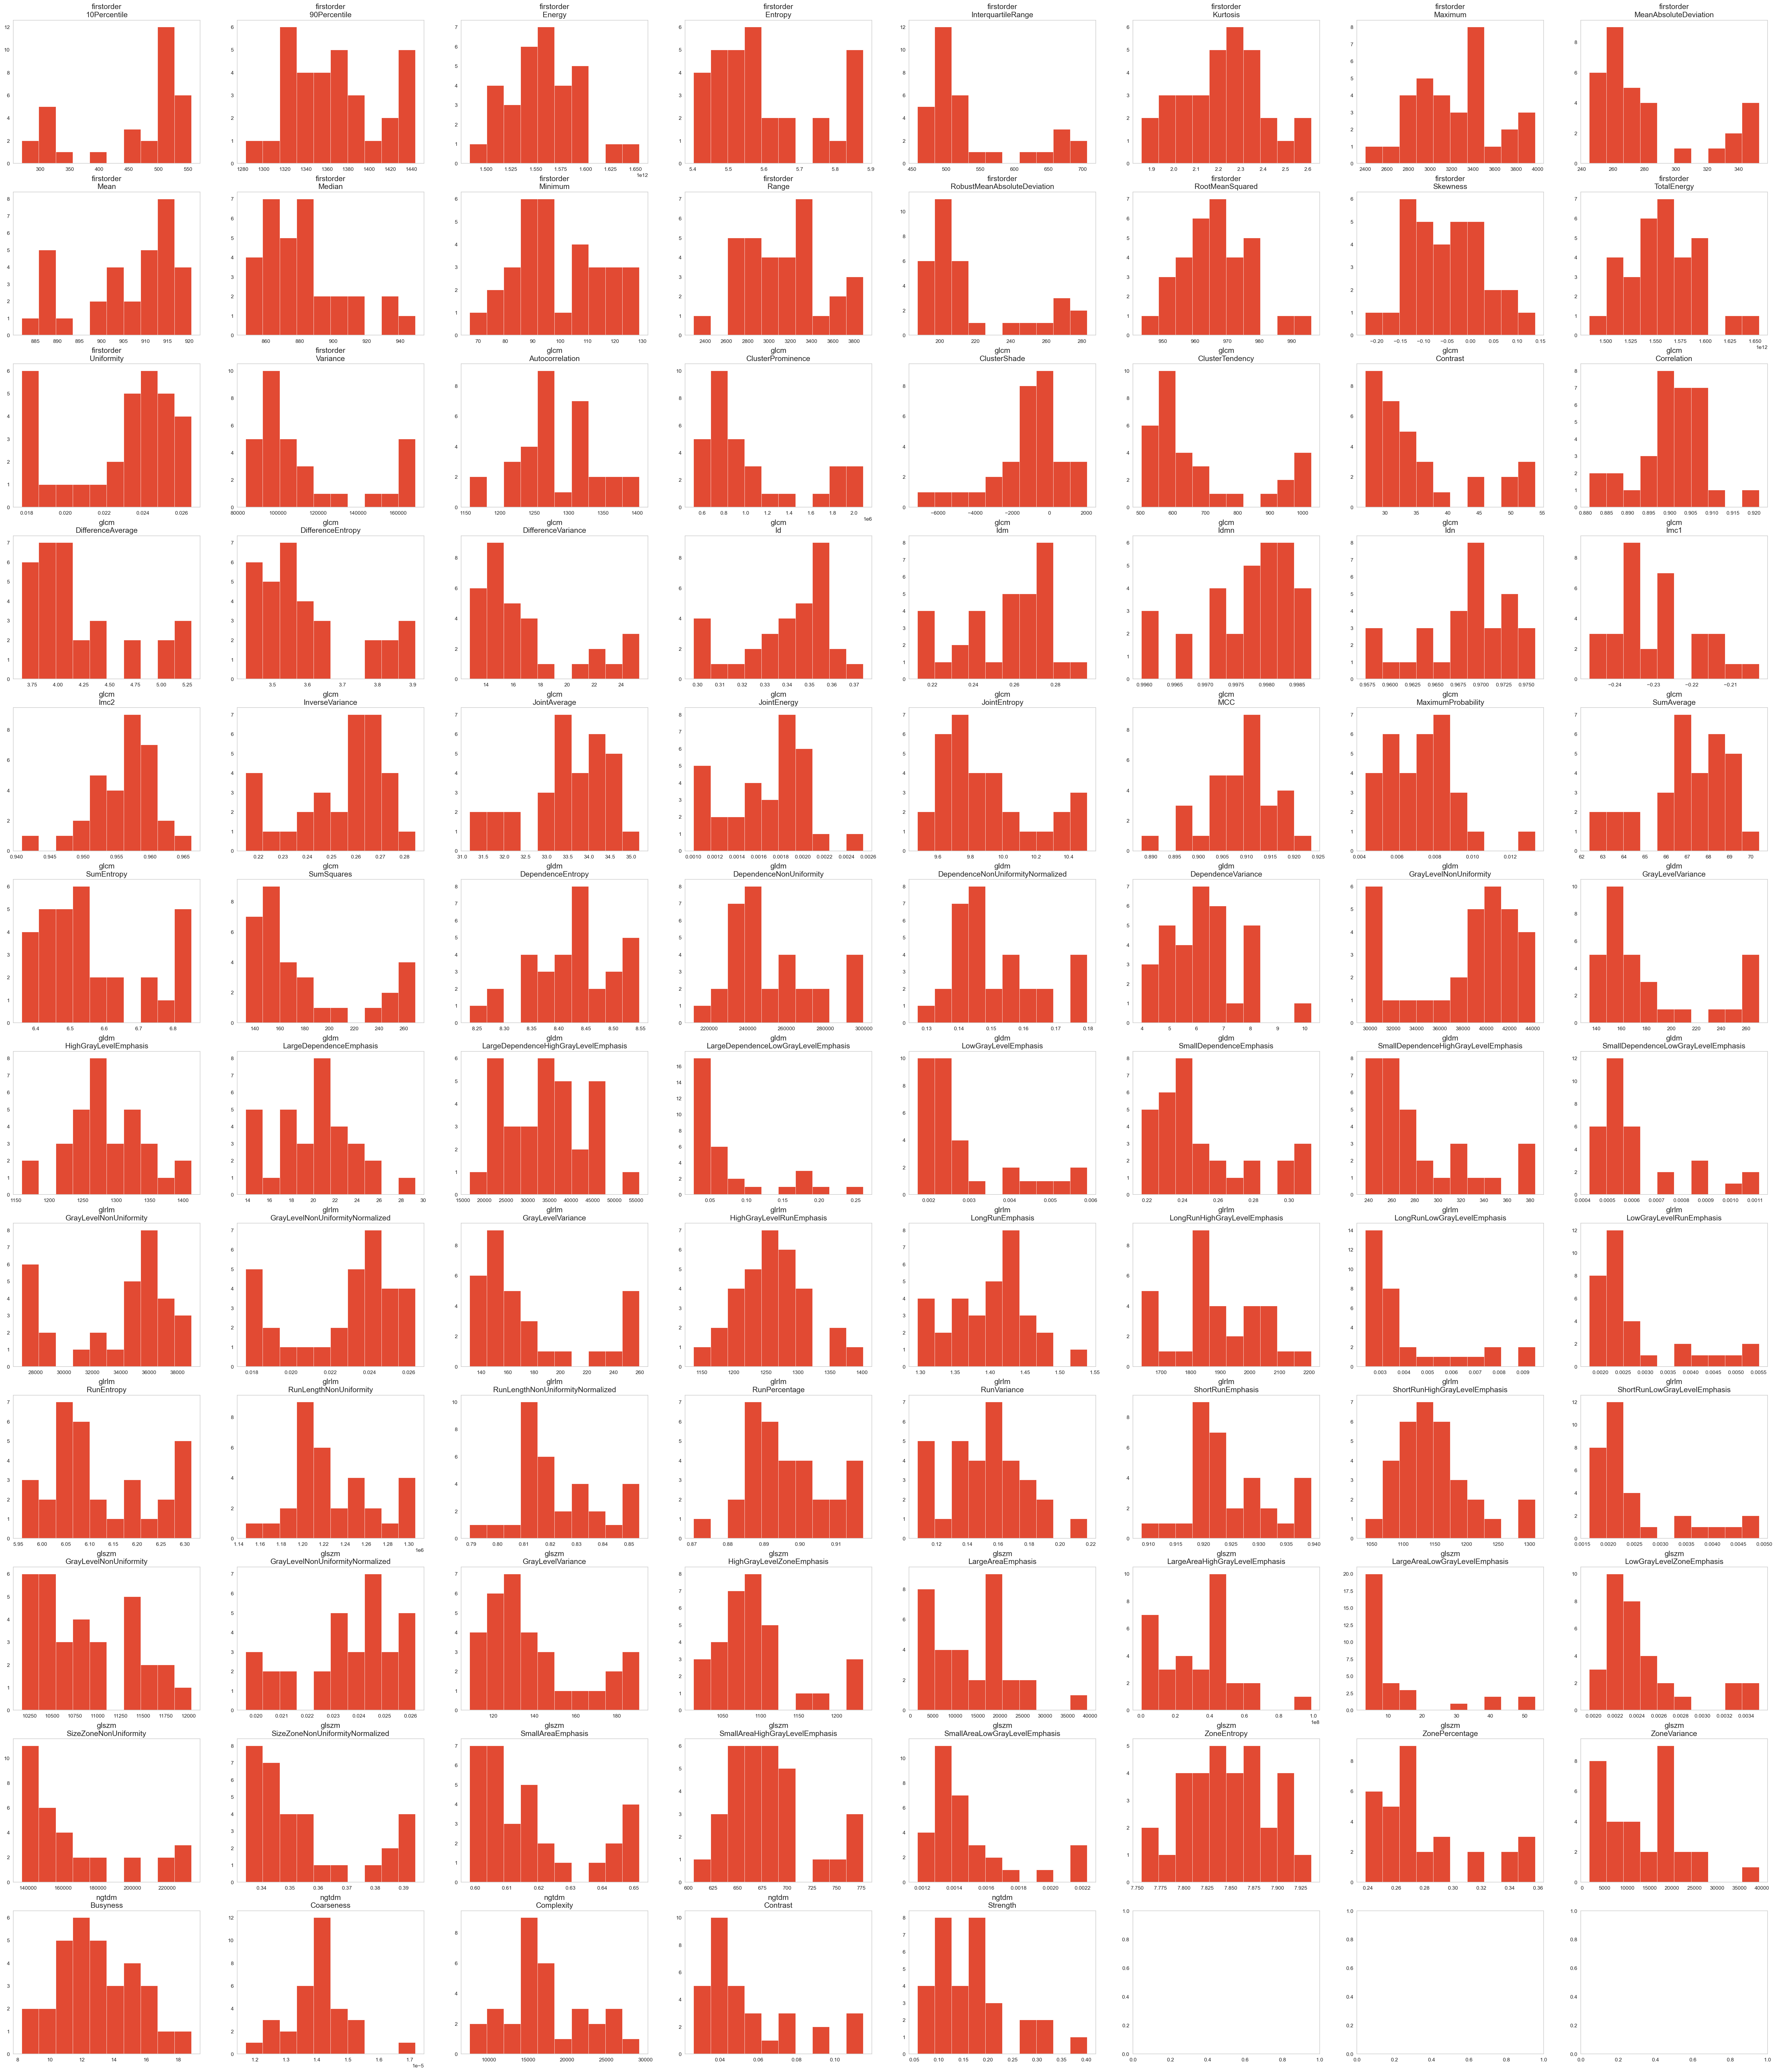

In [18]:
fig, m_axs = plt.subplots(12, 8, figsize=(60, 70))
for c_ax, c_var in zip(m_axs.flatten(), clean_col_names):
    c_ax.hist(clean_df[c_var].values, bins=10)
    c_ax.set_title('\n'.join(c_var.split(' ')))
fig.savefig('all_metrics.png')